In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/avg-aribnb-paris/Sheet 1.png
/kaggle/input/airbnb-listings-reviews/Airbnb Data/Listings.csv
/kaggle/input/airbnb-listings-reviews/Airbnb Data/Reviews.csv
/kaggle/input/airbnb-listings-reviews/Airbnb Data/Reviews_data_dictionary.csv
/kaggle/input/airbnb-listings-reviews/Airbnb Data/Listings_data_dictionary.csv


### Import required libraries

In [21]:
import sqlite3
import matplotlib.pyplot as plt

### Create a temporary SQLite Database & load data

In [22]:
conn = sqlite3.connect(':memory:')
listings = pd.read_csv(r"/kaggle/input/airbnb-listings-reviews/Airbnb Data/Listings.csv",encoding = "ISO-8859-1",low_memory=False)
listings.to_sql('airbnb_listings', conn, index = False)

279712

## Data cleanse

### Checking for info about data

In [23]:
query = 'PRAGMA table_info(airbnb_listings)'
pd.read_sql(query, conn)

,cid,name,type,notnull,dflt_value,pk
0,0,listing_id,INTEGER,0,None,0
1,1,name,TEXT,0,None,0
2,2,host_id,INTEGER,0,None,0
3,3,host_since,TEXT,0,None,0
4,4,host_location,TEXT,0,None,0
5,5,host_response_time,TEXT,0,None,0
6,6,host_response_rate,REAL,0,None,0
7,7,host_acceptance_rate,REAL,0,None,0
8,8,host_is_superhost,TEXT,0,None,0
9,9,host_total_listings_count,REAL,0,None,0


### Checking for missing values

In [24]:
query = '''
SELECT
    COUNT(*) as total_rows,
    SUM(CASE WHEN price IS NULL THEN 1 ELSE 0 END) AS missing_price,
    SUM(CASE WHEN bedrooms IS NULL THEN 1 ELSE 0 END) AS missing_bedrooms,
    SUM(CASE WHEN review_scores_rating IS NULL THEN 1 ELSE 0 END) AS missing_ratings
    FROM airbnb_listings
'''
pd.read_sql(query, conn)

,total_rows,missing_price,missing_bedrooms,missing_ratings
0,279712,0,29435,91405


### Identifying outliers

In [25]:
# Define a function to remove outliers
def remove_outliers(listings, price):
    Q1 = listings[price].quantile(0.25)
    Q3 = listings[price].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return listings[(listings[price] >= lower_bound) & (listings[price] <= upper_bound)]

# Apply to price column
listings = remove_outliers(listings, 'price')

# Check the new distribution
listings['price'].describe()


count    248317.000000
mean        232.466372
std         241.398742
min           0.000000
25%          70.000000
50%         125.000000
75%         300.000000
max        1072.000000
Name: price, dtype: float64

In [26]:
listings.to_sql('airbnb_listings', conn, index = False, if_exists = 'replace')

248317

### Handling missing values: replacing missing bedrooms and ratings with their average values

In [27]:
query = '''
UPDATE airbnb_listings
SET bedrooms = ROUND((SELECT AVG(bedrooms) FROM airbnb_listings), 0)
WHERE bedrooms IS NULL
'''
conn.execute(query)
conn.commit()

In [28]:
query = '''
UPDATE airbnb_listings
SET review_scores_rating = (SELECT AVG(review_scores_rating) FROM airbnb_listings)
WHERE review_scores_rating IS NULL
'''
conn.execute(query)
conn.commit()

In [29]:
query = '''
SELECT city, COUNT(city) 
FROM airbnb_listings 
GROUP BY city
ORDER BY COUNT(city) DESC
LIMIT 3
'''
pd.read_sql(query, conn)

,city,COUNT(city)
0,Paris,64511
1,New York,36784
2,Sydney,32899


#### Column host_since: changing data type from text to date

In [30]:
listings['host_since'] = pd.to_datetime(listings['host_since'], format='mixed')

### How does the average price vary across different neighborhoods of Paris?

In [31]:
paris_prices_query = '''
SELECT neighbourhood, round(avg(price), 2) as avg_price_rounded, latitude, longitude 
from airbnb_listings 
where city = 'Paris'
group by neighbourhood
order by avg(price) desc
'''
paris_prices = pd.read_sql_query(paris_prices_query, conn)
paris_prices.head()

,neighbourhood,avg_price_rounded,latitude,longitude
0,Elysee,186.81,48.88112,2.31712
1,Louvre,154.02,48.86064,2.34266
2,Luxembourg,147.72,48.84477,2.32525
3,Palais-Bourbon,145.45,48.85994,2.32425
4,Hotel-de-Ville,140.90,48.85681,2.35678


### Representation on a map

In [32]:
import folium

In [33]:
paris_map = folium.Map(location=[48.8566, 2.3522], zoom_start=12)

folium.Marker(
    location=[48.8566, 2.3522],
    popup="Paris Center"
).add_to(paris_map)

for index, row in paris_prices.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Neighbourhood: {row['neighbourhood']}<br>Avg Price: €{row['avg_price_rounded']}",
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(paris_map)


In [34]:
paris_map

#### Since the map above (generated using the Folium library) is not convenient for comparing the average Airbnb prices across different neighborhoods, I have created a visualization in Tableau. To do this, I merged the listings file with a geoJSON file containing information about the neighborhoods in Paris.


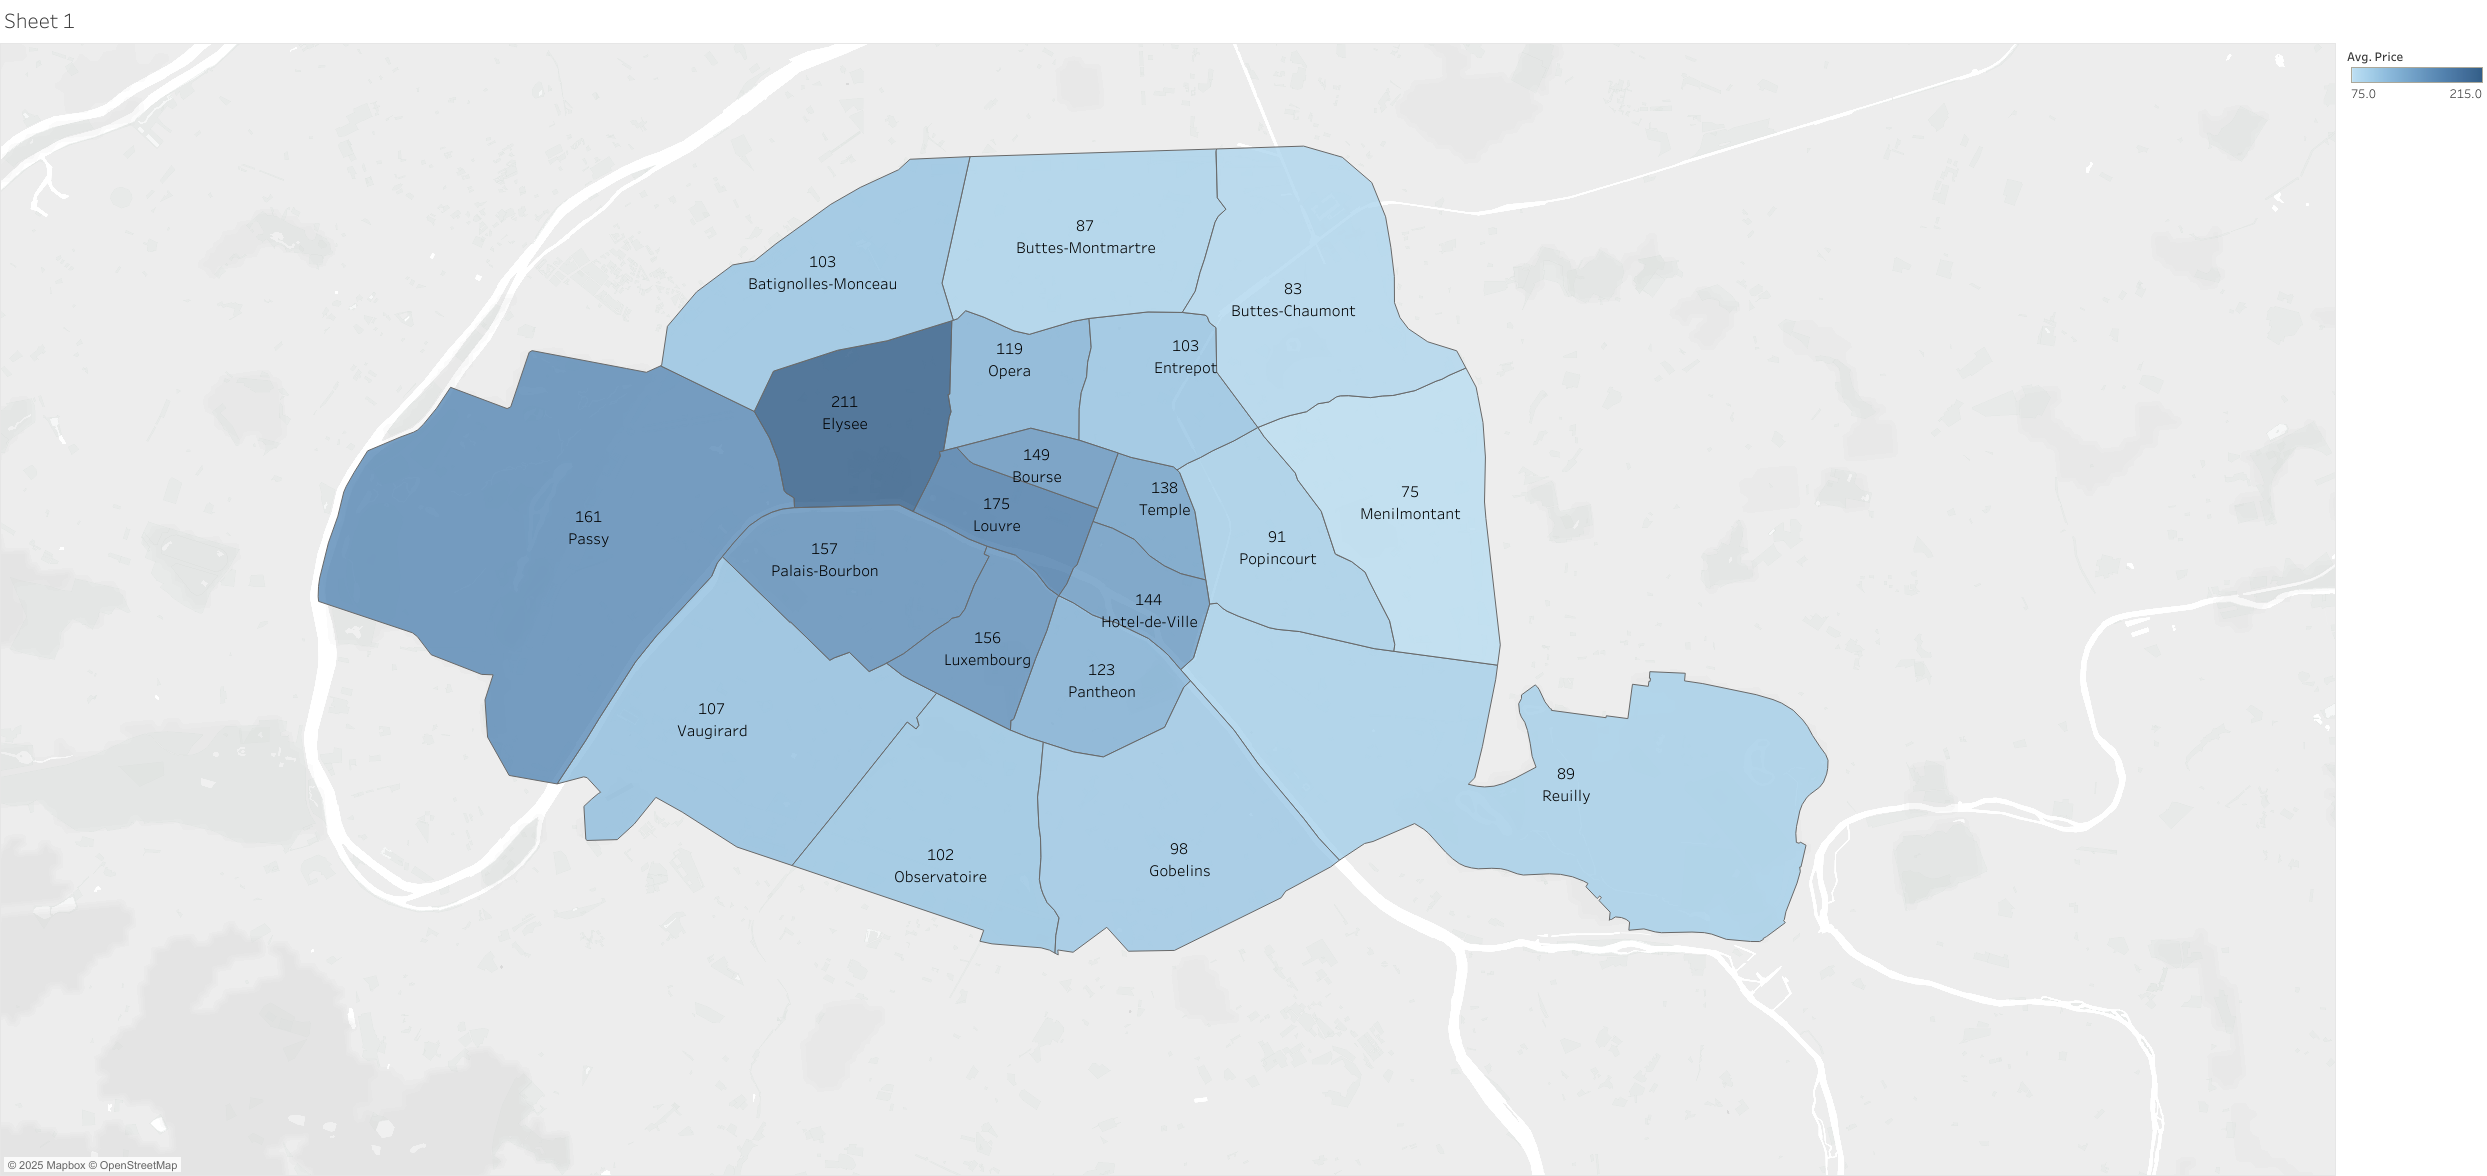

In [35]:
from IPython.display import display
from PIL import Image

image_path = "/kaggle/input/avg-aribnb-paris/Sheet 1.png"
img = Image.open(image_path)
display(img)

In [36]:
# Extracting year and month from 'host_since' date
prices_overtime['month'] = prices_overtime['host_since'].dt.to_period('M')

# Grouping by month and calculating the average price
prices_overtime_monthly = prices_overtime.groupby('month').agg({'price': 'mean'}).reset_index()

# Checking for missing data
prices_overtime_monthly = prices_overtime_monthly.dropna()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(prices_overtime_monthly['month'].astype(str), prices_overtime_monthly['price'], linestyle='-', color='b')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.title('Average Price by Month (Grouped)')
plt.xticks([i for i in range(0, len(prices_overtime_monthly), 12)], 
           [str(prices_overtime_monthly['month'].iloc[i].year) for i in range(0, len(prices_overtime_monthly), 12)])

plt.tight_layout()
plt.show()


NameError: name 'prices_overtime' is not defined